# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.22 which is incompatible.


The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [2]:
#!pip3 install 

In [3]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [6]:
for i in range(5):                                         # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        # print(rewards )
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 0.09500000160187483
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291


When finished, you can close the environment.

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

In [11]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F


def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=64, fc2_units=64):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        self.bn = nn.BatchNorm1d(fc1_units)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions."""
        x = F.relu(self.fc1(state))
        x = self.bn(x)
        x = F.relu(self.fc2(x))
        return F.tanh(self.fc3(x))


class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, states_size, actions_size, seed, fcs1_units=128, fc2_units=128):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fcs1_units (int): Number of nodes in the first hidden layer
            fc2_units (int): Number of nodes in the second hidden layer
        """
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fcs1 = nn.Linear(states_size + actions_size, fcs1_units)
        self.fc2 = nn.Linear(fcs1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)
        self.bn = nn.BatchNorm1d(fcs1_units)
        self.reset_parameters()

    def reset_parameters(self):
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        x = torch.cat((state, action), dim=1)
        x = F.relu(self.fcs1(x))
        x = self.bn(x)
        x = F.relu(self.fc2(x))
        return self.fc3(x)


In [12]:
class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.15):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.array([random.random() for i in range(len(x))])
        self.state = x + dx
        return self.state

In [13]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [14]:
import copy
from collections import namedtuple, deque
import numpy as np
import random


import torch
import torch.nn.functional as F
import torch.optim as optim

# from model import Actor, Critic

BUFFER_SIZE = int(1e6)  # replay buffer size
BATCH_SIZE = 256        # minibatch size
GAMMA = 0.95            # discount factor
TAU = 1e-2              # for soft update of target parameters
LR_ACTOR = 3e-3         # learning rate of the actor 
LR_CRITIC = 3e-3        # learning rate of the critic
WEIGHT_DECAY = 0        # L2 weight decay

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Agent():
    """Interacts with and learns from the environment."""
    
    def __init__(self, agent_index, state_size, action_size, random_seed, num_agents=1):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            random_seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(random_seed)
        self.agent_index = agent_index

        # Actor Network (w/ Target Network)
        self.actor_local = Actor(state_size, action_size, random_seed).to(device)
        self.actor_target = Actor(state_size, action_size, random_seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR)

        # Critic Network (w/ Target Network)
        self.critic_local = Critic(state_size*num_agents, action_size*num_agents, random_seed).to(device)
        self.critic_target = Critic(state_size*num_agents, action_size*num_agents, random_seed).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)

        # Noise process
        self.noise = OUNoise(action_size, random_seed)

        # Replay memory
        # self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, random_seed)
    
    def step(self, state, action, reward, next_state, done):
        """Save experience in replay memory, and use random sample from buffer to learn."""
        # Save experience / reward
        self.memory.add(state, action, reward, next_state, done)

        # Learn, if enough samples are available in memory
        if len(self.memory) > BATCH_SIZE:
            experiences = self.memory.sample()
            self.learn(experiences, GAMMA)

    def act(self, state, add_noise=True):
        """Returns actions for given state as per current policy."""
        state = torch.from_numpy(state).float().to(device)
        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()
        if add_noise:
            action += self.noise.sample()
        return np.clip(action, -1, 1)

    def reset(self):
        self.noise.reset()

    def learn(self, experiences, gamma):
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value

        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences
        
        # even_indices = torch.tensor(range(0, states.shape[0], 2))
        # odd_indices = torch.tensor(range(1, states.shape[0], 2))
        actor_indices = torch.tensor(range(self.agent_index, states.shape[0], 2))
        other_indices = torch.tensor(range(1-self.agent_index, states.shape[0], 2))
        
        #states_selected = states.index_select(0, even_indices)
        #states_selected = states.index_select(0, odd_indices)
        
        actor_states = states.index_select(0, actor_indices)
        actor_actions = actions.index_select(0, actor_indices)
        actor_next_states = next_states.index_select(0, actor_indices)
        actor_rewards = rewards[:, self.agent_index]
        actor_dones = dones[:, self.agent_index]

        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        
        actions_next = self.actor_target(actor_next_states)

        input_critic_actions_next = ()
        for i in range(len(actions)):
            if self.agent_index == 0:
                input_critic_actions_next.append(actions_next[i])
                input_critic_actions_next.append(actor_actions[2*i+1])
            else:
                input_critic_actions_next.append(actor_actions[2*i])
                input_critic_actions_next.append(actions_next[i])
            
        
        Q_targets_next = self.critic_target(next_states, input_critic_actions_next)
        # Compute Q targets for current states (y_i)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        # Compute critic loss
        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        actions_pred = self.actor_local(actor_states)
        for i in range(len(actions)):
            if self.actor_index == 0:
                input_critic_actions_pred.append(actions_pred[i])
                input_critic_actions_pred.append(actor_actions[2*i+1])
            else:
                input_critic_actions_next.append(actor_actions[2*i])
                input_critic_actions_next.append(actions_pred[i])
        
        
        actor_loss = -self.critic_local(states, input_critic_actions).mean()
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic_local, self.critic_target, TAU)
        self.soft_update(self.actor_local, self.actor_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)



In [15]:
RANDOM_SEED = 2
agents = [Agent(state_size=state_size, action_size=action_size, random_seed=RANDOM_SEED, num_agents=2, agent_index=0),
          Agent(state_size=state_size, action_size=action_size, random_seed=RANDOM_SEED, num_agents=2, agent_index=1)]


def learn(test_agent, experiences, gamma):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    states, actions, rewards, next_states, dones = experiences
    agent_indices = torch.tensor(range(test_agent.agent_index*test_agent.state_size, test_agent.state_size*(test_agent.agent_index+1))).to(device)
    other_index = 1 - test_agent.agent_index
    other_indices = torch.tensor(range(other_index*test_agent.state_size, test_agent.state_size*(other_index+1))).to(device)

    # even_indices = torch.tensor(range(0, states.shape[0], 2))
    # odd_indices = torch.tensor(range(1, states.shape[0], 2))
    # actor_indices = torch.tensor(range(test_agent.agent_index, states.shape[0], 2))
    # other_indices = torch.tensor(range(1-test_agent.agent_index, states.shape[0], 2))

    actor_states = states.index_select(1, agent_indices).to(device)
    # actor_states = states.index_select(1, agent_indices)
    # actor_actions = actions.index_select(0, actor_indices)
    actor_next_states = next_states.index_select(1, agent_indices)
    # actor_rewards = rewards[:, test_agent.agent_index]
    # actor_dones = dones[:, test_agent.agent_index]

    # ---------------------------- update critic ---------------------------- #
    # Get predicted next-state actions and Q values from target models
    actions_next = test_agent.actor_target(actor_next_states)
    # other_actor_actions = actions.index_select(0, other_indices)

    if test_agent.agent_index==0:
        input_critic = torch.cat((actions_next, actions[:,2:4]), dim=1).to(device)
    else:
        input_critic = torch.cat((actions[:,0:2], actions_next), dim=1).to(device)

    Q_targets_next = test_agent.critic_target(next_states, input_critic)


    # Compute Q targets for current states (y_i)
    Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
    # Compute critic loss
    Q_expected = test_agent.critic_local(states, actions)
    critic_loss = F.mse_loss(Q_expected, Q_targets)

    # Minimize the loss
    test_agent.critic_optimizer.zero_grad()
    critic_loss.backward()
    test_agent.critic_optimizer.step()
    
    
    actions_pred = test_agent.actor_local(actor_states)
    if test_agent.agent_index==0:
        input_critic_actions = torch.cat((actions_pred, actions[:,2:4]), dim=1).to(device)
    else:
        input_critic_actions = torch.cat((actions[:,0:2], actions_pred), dim=1).to(device)

    actor_loss = - test_agent.critic_local(states, input_critic_actions).mean().to(device)

    # Minimize the loss
    test_agent.actor_optimizer.zero_grad()
    actor_loss.backward()
    test_agent.actor_optimizer.step()

    # ----------------------- update target networks ----------------------- #
    test_agent.soft_update(test_agent.critic_local, test_agent.critic_target, TAU)
    test_agent.soft_update(test_agent.actor_local, test_agent.actor_target, TAU)
    
    return test_agent



In [16]:
import time
BUFFER_SIZE = int(1e6)
memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, RANDOM_SEED)
total_scores = []
scores_deque = deque(maxlen=100)

In [17]:
#!mv workspace-utils.py workspace_utils.py

In [18]:
import workspace_utils

Average score for 0 episode:  = 0.0, max episode length in the last 100 episodes was 12
Started learning
Average score for 100 episode:  = 0.0009000000171363354, max episode length in the last 100 episodes was 29
Average score for 200 episode:  = 0.002700000051409006, max episode length in the last 100 episodes was 30
Average score for 300 episode:  = 0.004800000078976154, max episode length in the last 100 episodes was 51
Average score for 400 episode:  = 0.01650000026449561, max episode length in the last 100 episodes was 38
Average score for 500 episode:  = 0.023900000397115945, max episode length in the last 100 episodes was 50
Average score for 600 episode:  = 0.08160000134259462, max episode length in the last 100 episodes was 68
Average score for 700 episode:  = 0.0823000012896955, max episode length in the last 100 episodes was 257
Average score for 800 episode:  = 0.05910000102594495, max episode length in the last 100 episodes was 125
Average score for 900 episode:  = 0.10140

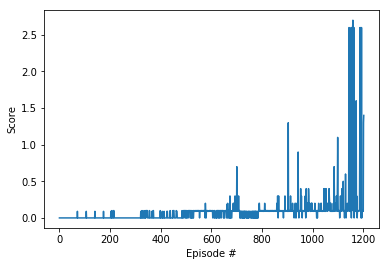

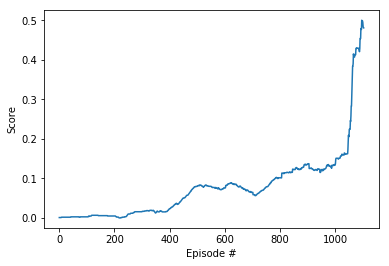

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
tic = time.time()
started_learning = False
max_episode_length = 0


from workspace_utils import active_session
with active_session():

    for i in range(10000):                                         # play game for 5 episodes
        env_info = env.reset(train_mode=True)[brain_name]         # reset the environment    
        states = env_info.vector_observations                     # get the current state (for each agent)
        scores = np.zeros(num_agents)
        agents[0].reset()
        agents[1].reset()
        # print(f"Episode {i}")

        j = 0
        while True:
            action_1 = agents[0].act(np.expand_dims(states[0, :], axis=0))
            action_2 = agents[1].act(np.expand_dims(states[1, :], axis=0))

            actions = np.concatenate((action_1, action_2), axis=0)

            # actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
            actions = np.clip(actions, -1, 1)                    # all actions between -1 and 1
            env_info = env.step(actions)[brain_name]             # send all actions to tne environment
            next_states = env_info.vector_observations           # get next state (for each agent)
            rewards = env_info.rewards                           # get reward (for each agent)
            dones = env_info.local_done
            # see if episode finished

            mem_states = np.hstack((states[0,:], states[1,:]))
            mem_actions = np.hstack((actions[0,:], actions[1,:]))
            mem_next_states = np.hstack((next_states[0,:], next_states[1,:]))


            # Replay memory
            memory.add(mem_states, mem_actions, rewards, mem_next_states, dones)

            if len(memory) > BATCH_SIZE:
                if not started_learning:
                    started_learning = True
                    print("Started learning")
                experiences = memory.sample()
                agents[0] = learn(agents[0], experiences, GAMMA)
                agents[1] = learn(agents[1], experiences, GAMMA)
            scores += env_info.rewards                         # update the score (for each agent)
            states = next_states

            # roll over states to next time step
            if np.any(dones):                                  # exit loop if episode finished
                break
            j = j + 1
            if j > max_episode_length:
                max_episode_length = j

        total_scores.append(np.max(scores))
        scores_deque.append(np.max(scores))
        if i % 100 == 0:
            print(f'Average score for {i} episode: ' +
            f' = {np.mean(scores_deque)}, ' +
            f'max episode length in the last 100 episodes was {max_episode_length}')
            max_episode_length = 0

        if np.mean(scores_deque) > 0.5:
            torch.save(agents[0].actor_local.state_dict(), 'checkpoint_actor0.pth')
            torch.save(agents[0].critic_local.state_dict(), 'checkpoint_critic0.pth')
            torch.save(agents[1].actor_local.state_dict(), 'checkpoint_actor1.pth')
            torch.save(agents[1].critic_local.state_dict(), 'checkpoint_critic1.pth')

            print('\n Score is over 0.5 so objective is fullfilled. Stopping training.')
            break

    toc = time.time()
    print(f"Training lasted for {(toc - tic) / 60} minutes")
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(1, len(total_scores)+1), total_scores)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.show()

    scores_average = []
    scores_len = len(total_scores)

    for i in range(scores_len - 100):
        scores_average.append(np.mean(total_scores[i:(i+99)]))
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(1, len(scores_average)+1), scores_average)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.show()


    
    

In [ ]:
# env.close()

## Learning rate experiments

learning rate 0.0001 tau = 0.01 gamma = 0.95 network =64
len = 2


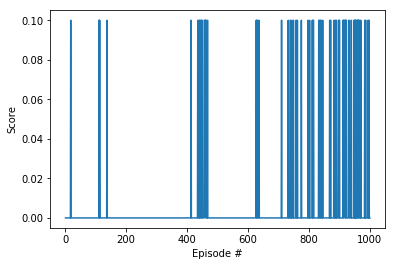

learning rate 0.001 tau = 0.001 network layers = 64


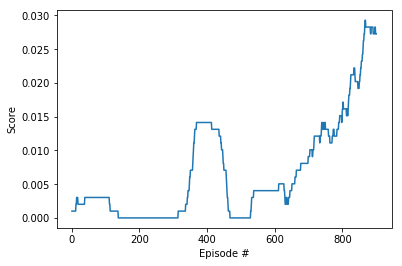

 Better final progress steeping curve but overal progress small thane 0.001 so lets stick with that one for now.


In [21]:
# third experiment
print("learning rate 0.0001 tau = 0.01 gamma = 0.95 network =64")
print(f"len = {len(scores)}")
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(total_scores)+1), total_scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()
scores_average = []
scores_len = len(total_scores)

for i in range(scores_len - 100):
    scores_average.append(np.mean(total_scores[i:(i+99)]))
print("learning rate 0.001 tau = 0.001 network layers = 64")
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores_average)+1), scores_average)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

print(" Better final progress steeping curve but overal progress small thane 0.001 so lets stick with that one for now.")

learning rate 0.001 tau = 0.01 gamma = 0.95 network =64
len = 2


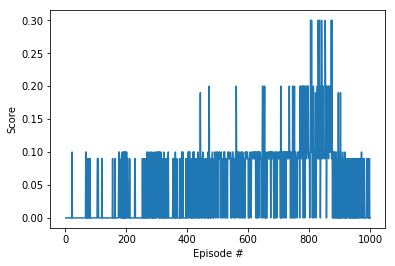

learning rate 0.001 tau = 0.001 network layers = 64


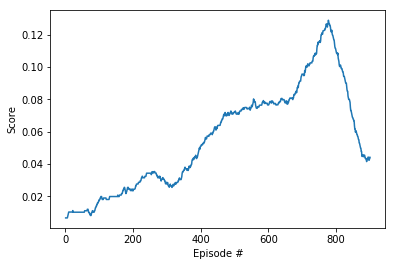

impression : ?


In [19]:
# second experiment
print("learning rate 0.001 tau = 0.01 gamma = 0.95 network =64")
print(f"len = {len(scores)}")
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(total_scores)+1), total_scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()
scores_average = []
scores_len = len(total_scores)

for i in range(scores_len - 100):
    scores_average.append(np.mean(total_scores[i:(i+99)]))
print("learning rate 0.001 tau = 0.001 network layers = 64")
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores_average)+1), scores_average)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

print("impression : l")

learning rate 0.01 tau = 0.01 gamma = 0.95 network =64
len = 2


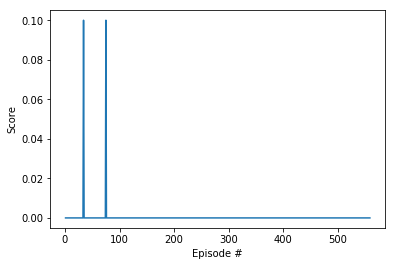

learning rate 0.001 tau = 0.001 network layers = 64


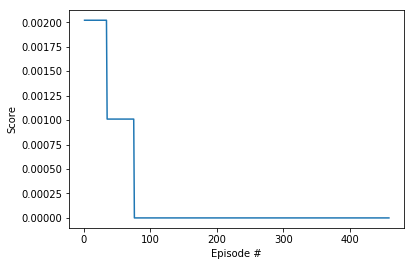

impression : no progress


In [19]:
# first experiment
print("learning rate 0.01 tau = 0.01 gamma = 0.95 network = 64 layers")
print(f"len = {len(scores)}")
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(total_scores)+1), total_scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()
scores_average = []
scores_len = len(total_scores)

for i in range(scores_len - 100):
    scores_average.append(np.mean(total_scores[i:(i+99)]))
print("learning rate 0.001 tau = 0.001 network layers = 64")
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores_average)+1), scores_average)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

print("impression : no progress")

In [19]:
len(scores_average)

9233

## Netowork arhitecture experiments


We have already tried network with 64 layers, now we can try the one with 128 and 32 neurons and compare results. We will set learning rate to 0.001

learning rate 0.001 tau = 0.01 gamma = 0.95 network = 32
len = 2


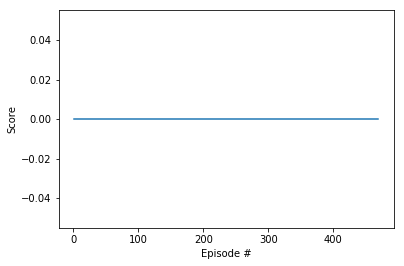

learning rate 0.001 tau = 0.001 network layers = 64


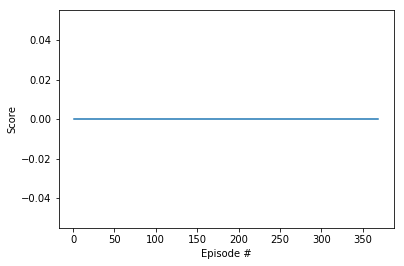

impression: 


In [18]:
print("learning rate 0.001 tau = 0.01 gamma = 0.95 network = 32")
print(f"len = {len(scores)}")
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(total_scores)+1), total_scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()
scores_average = []
scores_len = len(total_scores)

for i in range(scores_len - 100):
    scores_average.append(np.mean(total_scores[i:(i+99)]))
print("learning rate 0.001 tau = 0.001 network layers = 64")
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores_average)+1), scores_average)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()


Impression: Worst than network with 64 units, no progress at all.

learning rate 0.001 tau = 0.01 gamma = 0.95 network = 128
len = 2


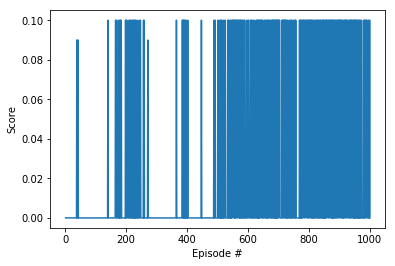

learning rate 0.001 tau = 0.001 network layers = 64


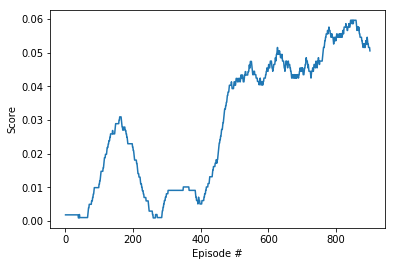

impression: 


In [19]:
print("learning rate 0.001 tau = 0.01 gamma = 0.95 network = 128")
print(f"len = {len(scores)}")
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(total_scores)+1), total_scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()
scores_average = []
scores_len = len(total_scores)

for i in range(scores_len - 100):
    scores_average.append(np.mean(total_scores[i:(i+99)]))
print("learning rate 0.001 tau = 0.001 network layers = 128")
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores_average)+1), scores_average)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

print("impression: ")

Similar as network with 64 units. FInal result seems to be a bit worst. It seems that something causes learning to fall after some time. It might make more sense to extend the number of episodes for both networks. We could also play with noise parameters, maybe they are causing this fall. Lets try network with 256 units for completion .  

learning rate 0.001 tau = 0.01 gamma = 0.95 network =256


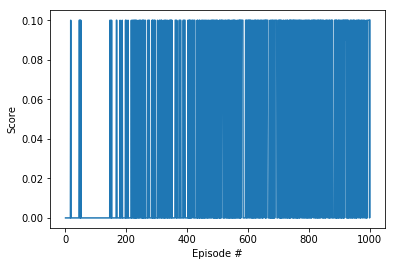

learning rate 0.001 tau = 0.01 network layers = 256


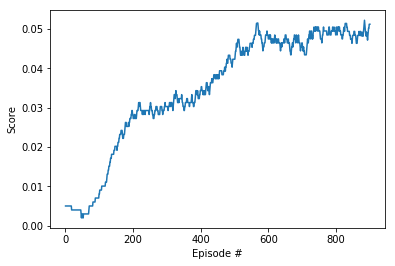

In [22]:
print("learning rate 0.001 tau = 0.01 gamma = 0.95 network =256")
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(total_scores)+1), total_scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()
scores_average = []
scores_len = len(total_scores)

for i in range(scores_len - 100):
    scores_average.append(np.mean(total_scores[i:(i+99)]))
print("learning rate 0.001 tau = 0.01 network layers = 256")
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores_average)+1), scores_average)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

Impression: a bit worse result than with 128 but also rising, before preceeding with 64 candidate, we can try changing noise parameters, since thay were very important in the last lesson. We will change sigma parameter to 0.15, 0.1 abd 0.3

## Experiments with noise parameters

We will fix network with 64 units and play with noise parameters, lets try sigma =0.05 and sigma = 0.3 and report results, after that lets run a training for a longer time for a network with 64 units.

learning rate 0.001 tau = 0.01 gamma = 0.95 network =256 sigma =0.05


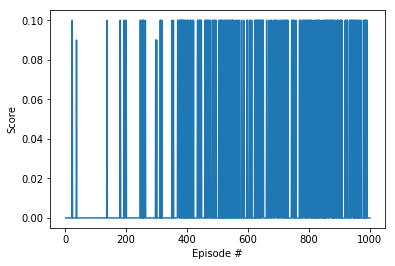

learning rate 0.001 tau = 0.01 network layers = 256


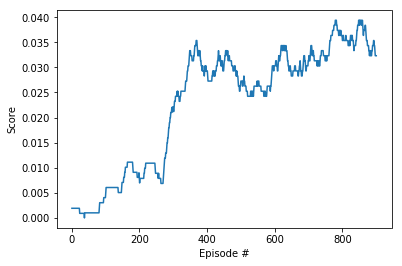

In [18]:
print("learning rate 0.001 tau = 0.01 gamma = 0.95 network =256 sigma =0.1")
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(total_scores)+1), total_scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()
scores_average = []
scores_len = len(total_scores)

for i in range(scores_len - 100):
    scores_average.append(np.mean(total_scores[i:(i+99)]))
print("learning rate 0.001 tau = 0.01 network layers = 256")
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores_average)+1), scores_average)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [ ]:
Again similiar results as before but slightly worst, lets try with sigma = 0.3 and compare results.

learning rate 0.001 tau = 0.01 gamma = 0.95 network = 256, sigma =0.3


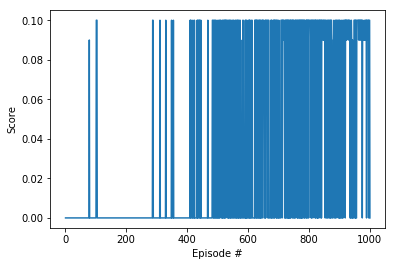

learning rate 0.001 tau = 0.01 network layers = 256


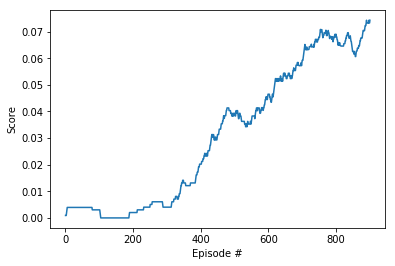

In [18]:
print("learning rate 0.001 tau = 0.01 gamma = 0.95 network = 256, sigma =0.3")
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(total_scores)+1), total_scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()
scores_average = []
scores_len = len(total_scores)

for i in range(scores_len - 100):
    scores_average.append(np.mean(total_scores[i:(i+99)]))
print("learning rate 0.001 tau = 0.01 network layers = 256")
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores_average)+1), scores_average)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [ ]:
Results are similar as when sigma=0.1, but one could argue that more noise can lead to better exploration and learning process looks more stable so lets leave sigma to 0.3 and run traaining for a very long time.

learning rate 0.001 tau = 0.01 gamma = 0.95 network = 256, sigma =0.3


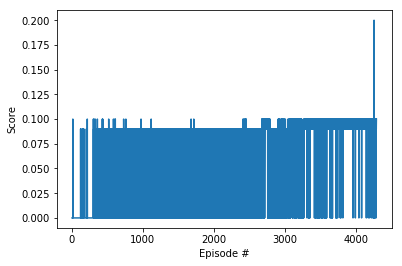

learning rate 0.001 tau = 0.01 network layers = 256


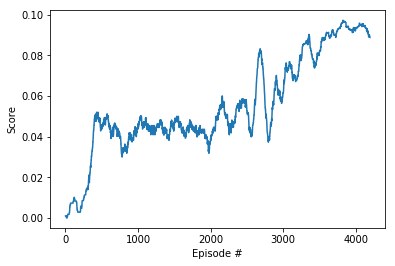

In [18]:
print("learning rate 0.001 tau = 0.01 gamma = 0.95 network = 256, sigma =0.3")
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(total_scores)+1), total_scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()
scores_average = []
scores_len = len(total_scores)

for i in range(scores_len - 100):
    scores_average.append(np.mean(total_scores[i:(i+99)]))
print("learning rate 0.001 tau = 0.01 network layers = 256")
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores_average)+1), scores_average)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [ ]:
Resulst seem stuck for a very long time, lets try larger network for start (units = 128). Maybe network cannot generilize.

In [ ]:
Greater network did not give better results. Return noise level to 0.15 and restarted training again to 5000 episodes.

In [ ]:
After some time i started looking for online resources We will increase batch size to 1024 and learning rate to 3e-3

In [ ]:
LR_ACTOR

learning rate 0.005 tau = 0.01 gamma = 0.95 network =256


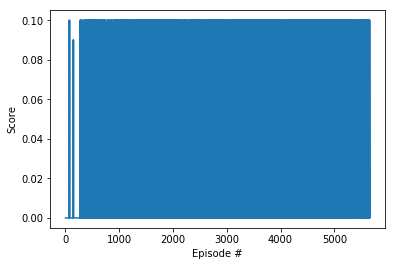

learning rate 0.001 tau = 0.01 network layers = 256


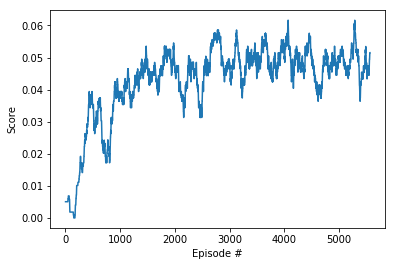

In [17]:
print(f"learning rate {LR_ACTOR} tau = 0.01 gamma = 0.95 network =256")
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(total_scores)+1), total_scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()
scores_average = []
scores_len = len(total_scores)

for i in range(scores_len - 100):
    scores_average.append(np.mean(total_scores[i:(i+99)]))
print("learning rate 0.001 tau = 0.01 network layers = 256")
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores_average)+1), scores_average)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [ ]:
Results for 

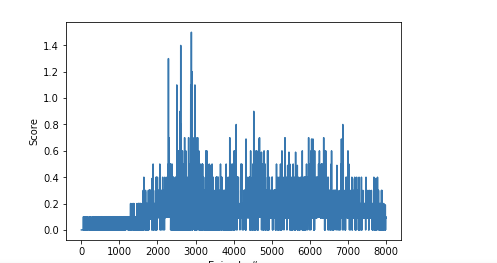

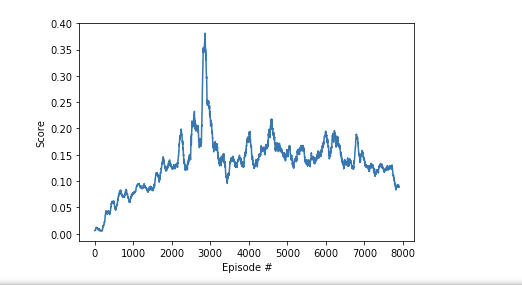



learning rate 0.005 tau = 0.01 gamma = 0.95 network =64, batch =128 


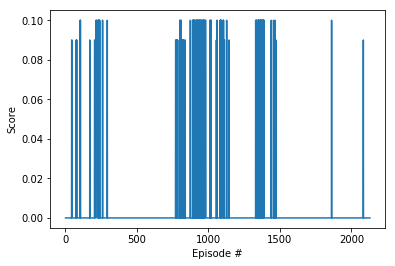

learning rate 0.001 tau = 0.01 network layers = 256


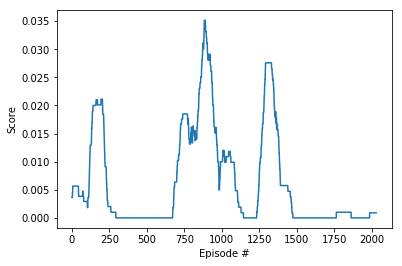

In [32]:
print(f"learning rate {LR_ACTOR} tau = 0.01 gamma = 0.95 network =64, batch =128 ")
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(total_scores)+1), total_scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()
scores_average = []
scores_len = len(total_scores)

for i in range(scores_len - 100):
    scores_average.append(np.mean(total_scores[i:(i+99)]))
print("learning rate 0.001 tau = 0.01 network layers = 256")
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores_average)+1), scores_average)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()